In [14]:
def water_advice(temp, rh, wind, solar, crop="date_palm"):
    input_df = pd.DataFrame([{
        "T2M": temp,
        "RH2M": rh,
        "WS2M": wind,
        "ALLSKY_SFC_SW_DWN": solar,
        "ET0_lag_1": df["ET0"].iloc[-1],
        "ET0_lag_3": df["ET0"].iloc[-3],
        "ET0_lag_7": df["ET0"].iloc[-7],
    }])
    
    predicted_et0 = model.predict(input_df)[0]
    water_need = recommend_irrigation(predicted_et0, crop)
    
    return predicted_et0, water_need


# Example usage
et0_val, water = water_advice(
    temp=35,
    rh=25,
    wind=3,
    solar=25,
    crop="date_palm"
)

print("Predicted ET0:", et0_val)
print("Recommended irrigation:", water, "mm/day")


Predicted ET0: -0.32875450899759745
Recommended irrigation: -0.2958790580978377 mm/day


In [13]:
# Crop coefficients (simplified but realistic)
CROP_KC = {
    "wheat": 0.7,
    "date_palm": 0.9,
    "vegetables": 1.05
}

def recommend_irrigation(et0, crop="date_palm"):
    kc = CROP_KC.get(crop, 0.9)
    return et0 * kc

# Example: generate recommendations for predictions
recommendations = [recommend_irrigation(e, crop="date_palm") for e in preds]

recommendations[:10]


[np.float64(-1.4768687168517136),
 np.float64(-1.7212542049203303),
 np.float64(-1.4353262228399861),
 np.float64(-0.8406056762681179),
 np.float64(-1.064572946032016),
 np.float64(-1.19067325599734),
 np.float64(-1.2372914397203747),
 np.float64(-1.177663219510939),
 np.float64(-0.8113618546648393),
 np.float64(-1.608680233053053)]

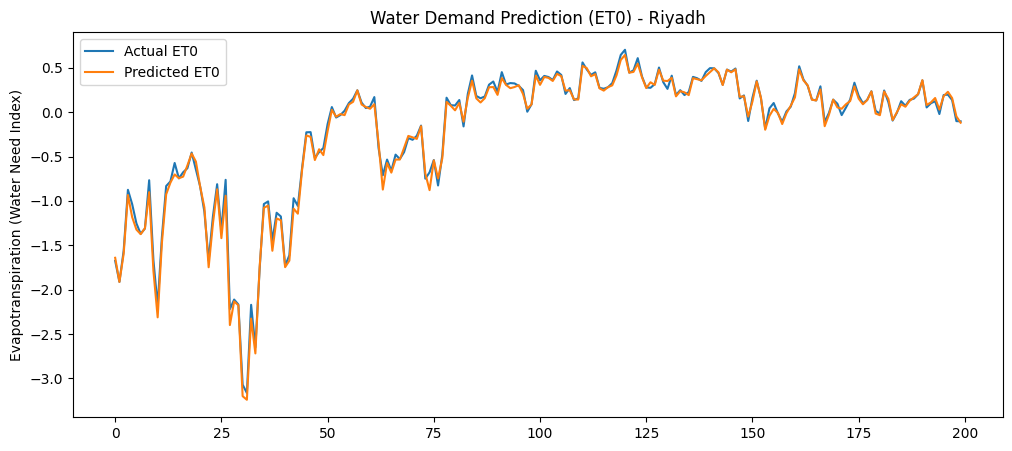

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual ET0")
plt.plot(preds[:200], label="Predicted ET0")
plt.legend()
plt.title("Water Demand Prediction (ET0) - Riyadh")
plt.ylabel("Evapotranspiration (Water Need Index)")
plt.show()


In [10]:
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("ET0 MAE:", mae)
print("ET0 RMSE:", rmse)


ET0 MAE: 0.03761107561702432
ET0 RMSE: 0.05250623484760797


In [9]:
# Feature engineering
for lag in [1, 3, 7]:
    df[f"ET0_lag_{lag}"] = df["ET0"].shift(lag)

df_model = df.dropna()

X = df_model[["T2M", "RH2M", "WS2M", "ALLSKY_SFC_SW_DWN", 
              "ET0_lag_1", "ET0_lag_3", "ET0_lag_7"]]

y = df_model["ET0"]

# Time-series split
split = int(len(df_model)*0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [8]:
# FAO-inspired simplified evapotranspiration proxy
# This becomes our new target variable

df = pd.read_csv("../data/riyadh_climate.csv", index_col=0, parse_dates=True)

T = df["T2M"]
RH = df["RH2M"]
WS = df["WS2M"]
SR = df["ALLSKY_SFC_SW_DWN"]

# Simplified ET0 proxy (research-valid approximation)
df["ET0"] = (
    0.0023 * (T + 17.8) * (SR ** 0.5)
    + 0.1 * WS
    - 0.05 * RH
)

df[["ET0"]].head()


,ET0
2020-01-01,-1.381545
2020-01-02,-1.240470
2020-01-03,-0.840343
2020-01-04,-1.214659
2020-01-05,-2.773636


<Axes: title={'center': 'Feature Importance'}>

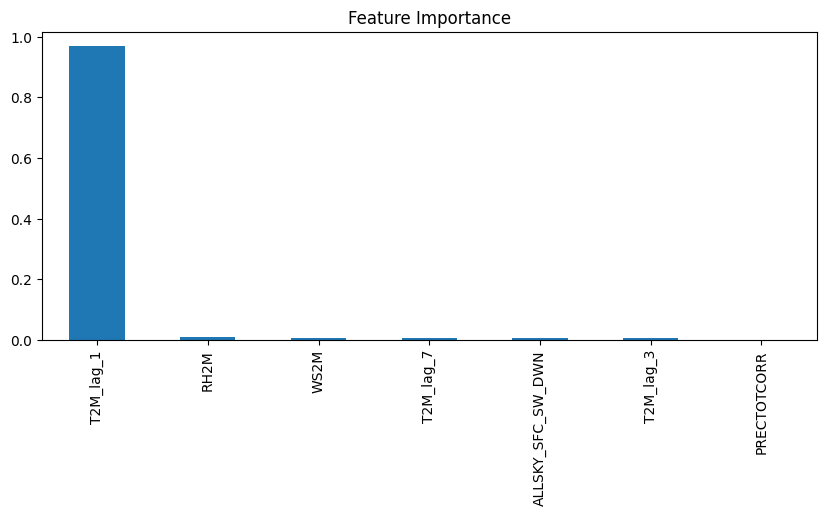

In [7]:
import pandas as pd

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind="bar", figsize=(10,4), title="Feature Importance")


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1.0250807560137454
RMSE: 1.3846624646449264


In [4]:
!pip install scikit-learn

from sklearn.model_selection import train_test_split

X = df_model.drop(columns=["T2M"])
y = df_model["T2M"]

# Time-series safe split
split_index = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 4.9 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.0 MB 4.3 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/8.0 MB 4.1 MB/s eta 0:00:02
   ----------------- ---------------------- 3.4/8.0 MB 4.0 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.0 MB 4.0 MB/s eta 0:00:01
   ------------------------ --------------- 5.0/8.0 MB 3.9 MB/s eta 0:00:01
   ---------------------------- ----------- 5.8/8.0 MB 3.9 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.0 MB 3.9 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.0 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.0 MB 3.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 3.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/36.3 MB ? eta -:--:--
   - --------------------


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Create lag features (previous days influence future)
for lag in [1, 3, 7]:
    df[f"T2M_lag_{lag}"] = df["T2M"].shift(lag)

# Drop missing rows
df_model = df.dropna()

df_model.head()


,T2M,RH2M,PRECTOTCORR,WS2M,ALLSKY_SFC_SW_DWN,T2M_lag_1,T2M_lag_3,T2M_lag_7
2020-01-08,14.87,37.37,0.00,3.35,14.54,12.23,14.67,16.41
2020-01-09,15.85,39.27,0.06,2.49,12.60,14.87,11.15,18.06
2020-01-10,12.97,47.33,0.00,2.51,17.39,15.85,12.23,20.78
2020-01-11,10.80,40.98,0.00,4.61,16.22,12.97,14.87,21.55
2020-01-12,9.00,44.48,0.00,3.49,16.84,10.80,15.85,14.67


In [1]:
import pandas as pd

df = pd.read_csv("../data/riyadh_climate.csv", index_col=0, parse_dates=True)

df.head(), df.describe()


(              T2M   RH2M  PRECTOTCORR  WS2M  ALLSKY_SFC_SW_DWN
 2020-01-01  16.41  38.45         0.00  2.51              13.58
 2020-01-02  18.06  39.85         0.00  4.27              15.53
 2020-01-03  20.78  33.73         0.00  4.93              15.84
 2020-01-04  21.55  37.88         0.00  3.28              15.07
 2020-01-05  14.67  64.41         2.78  2.73               5.42,
                T2M         RH2M  PRECTOTCORR         WS2M  ALLSKY_SFC_SW_DWN
 count  1462.000000  1462.000000  1462.000000  1462.000000        1462.000000
 mean     26.394754    25.914166     0.200889     2.770205          21.932127
 std       8.315235    16.165743     1.416206     0.959284           5.273865
 min       6.300000     6.760000     0.000000     0.840000           3.720000
 25%      19.157500    13.850000     0.000000     2.040000          17.805000
 50%      27.195000    19.500000     0.000000     2.680000          22.865000
 75%      34.235000    34.805000     0.000000     3.390000          2